In [26]:
import numpy as np
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,7)})
sns.set_theme()

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

import shap
shap.initjs()

seed= 123

'''
import locale
locale.setlocale(locale.LC_ALL, "")

import subprocess
import time
import random

from scipy.stats import uniform, loguniform



from IPython.display import SVG, Image

# Models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor

'''

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


'\nimport locale\nlocale.setlocale(locale.LC_ALL, "")\n\nimport subprocess\nimport time\nimport random\n\nfrom scipy.stats import uniform, loguniform\n\n\n\nfrom IPython.display import SVG, Image\n\n# Models\nimport statsmodels.api as sm\nimport statsmodels.formula.api as smf\nfrom catboost import Pool, CatBoostRegressor, cv\nfrom lightgbm import LGBMRegressor\n\n'

In [2]:
# read frequency data
df_raw = pd.read_csv("/Users/davidbennett/Documents/freMTPL2freq.csv")
df_raw.IDpol = df_raw.IDpol.astype(int) # policy ID should be integer

# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
df_raw["Exposure"] = np.minimum(1, df_raw.Exposure)
df_raw["ClaimNb"] = np.minimum(4, df_raw.ClaimNb)

# import folds (to obtain the same subsamples and reproduce some results)
df_folds = pd.read_csv("/Users/davidbennett/Documents/freMTPL2freq_folds.csv")
df_folds.IDpol = df_folds.IDpol.astype(int) # policy ID should be integer
df = pd.merge(df_raw, df_folds, how='inner', on='IDpol')

print("\nNumber of data rows and columns: ", df.shape)
print("\nCheck the end of the data set:")
df.tail(6) # view end of dataset



Number of data rows and columns:  (678013, 13)

Check the end of the data set:


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold
678007,6114325,0,0.005479,E,6,4,40,68,B12,Regular,2733,R93,2
678008,6114326,0,0.002740,E,4,0,54,50,B12,Regular,3317,R93,3
678009,6114327,0,0.002740,E,4,0,41,95,B12,Regular,9850,R11,5
678010,6114328,0,0.002740,D,6,2,45,50,B12,Diesel,1323,R82,5
678011,6114329,0,0.002740,B,4,0,60,50,B12,Regular,95,R26,3
678012,6114330,0,0.002740,B,7,6,29,54,B12,Diesel,65,R72,5


In [3]:
# take claim number from severity file (see https://www.kaggle.com/code/floser/comparing-claims-fremtpl2freq-sev)
sev = pd.read_csv("/Users/davidbennett/Documents/freMTPL2sev.csv")
sev["ClaimNb"] = 1
sev_agg = sev.groupby("IDpol").sum("ClaimNb").drop(columns=['ClaimAmount'])
# checks, sums and counts
sev_agg.head()


,ClaimNb
IDpol,
139,1
190,1
414,1
424,2
463,1


In [4]:
# left join with claims frequency data (exposures, features and without questionable ClaimNb). 
df = pd.merge(df.drop(columns=['ClaimNb']), sev_agg, on="IDpol", how="left").fillna(0)

# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
df['ClaimNb'] = df['ClaimNb'].clip(upper=4)
df['Exposure'] = df['Exposure'].clip(upper=1)

# Show summary statistics
df.describe()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.528545,6.454631,7.044265,45.499122,59.761502,1792.422405,2.997021,0.038945
std,1.641783e+06,0.364081,2.050906,5.666232,14.137444,15.636658,3958.646564,1.413916,0.205026
min,1.000000e+00,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,1.000000,0.000000
25%,1.157951e+06,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,2.000000,0.000000
50%,2.272152e+06,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,3.000000,0.000000
75%,4.046274e+06,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,4.000000,0.000000
max,6.114330e+06,1.000000,15.000000,100.000000,100.000000,230.000000,27000.000000,5.000000,4.000000


In [5]:
df.ClaimNb.value_counts()

ClaimNb
0.0    653069
1.0     23571
2.0      1298
3.0        62
4.0        13
Name: count, dtype: int64

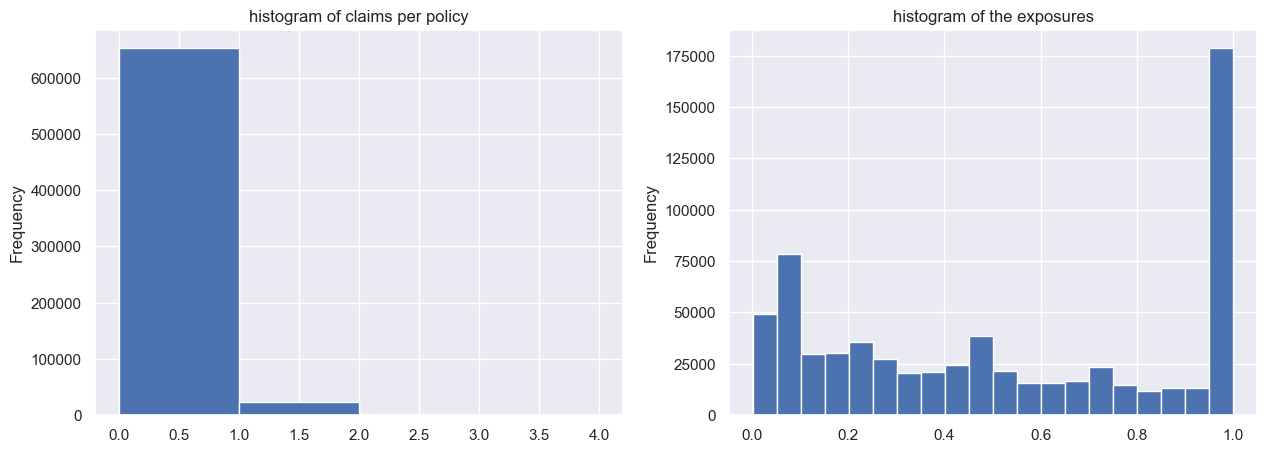

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1.set_title("histogram of claims per policy")
ax2.set_title("histogram of the exposures")
df.ClaimNb.plot.hist(bins=4,ax=ax1)
df.Exposure.plot.hist(bins=20, ax=ax2)
pass

In [7]:
df['Frequency'] = df['ClaimNb'] / df['Exposure']



In [8]:
dat2 = df.copy()
dat2["AreaGLM"] = dat2.Area.factorize()[0]
dat2["VehPowerGLM"] = np.minimum(9, dat2.VehPower)
# VehAgeGLM: 3 classes
mapping = {k: 3 if k>=11 else (2 if k>= 1 else 1) for k in range(111)}
dat2["VehAgeGLM"] = dat2.VehAge.map(mapping)
dat2["BonusMalusGLM"] = np.minimum(150, dat2.BonusMalus)
dat2["DensityGLM"] = np.log(dat2.Density)
dat2.head()

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fold,ClaimNb,Frequency,AreaGLM,VehPowerGLM,VehAgeGLM,BonusMalusGLM,DensityGLM
0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,1,0.0,0.0,0,5,1,50,7.104144
1,3,0.77,D,5,0,55,50,B12,Regular,1217,R82,5,0.0,0.0,0,5,1,50,7.104144
2,5,0.75,B,6,2,52,50,B12,Diesel,54,R22,1,0.0,0.0,1,6,2,50,3.988984
3,10,0.09,B,7,0,46,50,B12,Diesel,76,R72,1,0.0,0.0,1,7,1,50,4.330733
4,11,0.84,B,7,0,46,50,B12,Diesel,76,R72,2,0.0,0.0,1,7,1,50,4.330733


In [9]:
# Modified function PDX: Weighted Poisson Deviance
def PDW(pred, obs, ex=None):
    if ex is None:
        ex = np.ones(len(obs))
    deviance = 200 * np.sum(ex * (pred - obs + np.log((obs / pred) ** obs))) / np.sum(ex)
    return deviance

# Function PDW2: Print Poisson Deviance learn/test
def PDW2(txt, l_c, l_x, l_e, t_c, t_x, t_e):
    print("%s, Learn/Test: %.2f %% / %.2f %%" % (txt, PDW(l_c, l_x, l_e), PDW(t_c, t_x, t_e)))

# Function CF2: Print claim frequency
def CF2(txt, l_c, l_x, t_c, t_x):
    print("%s: %.2f %% / %.2f %%" % (txt, sum(l_c)/sum(l_x)*100, sum(t_c)/sum(t_x)*100))


# model names list
mname = []

# GLM2-Improvment-Index
II = []

# Dictionary for PD and model names
dict = {'improvement': II, 'modelname': mname}

In [10]:
# Defining learn and test sample based on previously defined folds
learn2 = dat2.loc[dat2.fold != 5,].copy()    # 80%
test2 = dat2.loc[dat2.fold == 5,].copy()     # 20%

CF2("Claim Frequency (Actual) Learn/Test", learn2.ClaimNb, learn2.Exposure, test2.ClaimNb, test2.Exposure)

Claim Frequency (Actual) Learn/Test: 7.37 % / 7.38 %


In [11]:
# Convert categorical variable into dummy/indicator variables.
df_ml = pd.get_dummies(df, drop_first=False, dtype='int')
print(df_ml.shape)
df_ml.head()

(678013, 51)


,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,fold,ClaimNb,Frequency,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,1,0.10,5,0,55,50,1217,1,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,3,0.77,5,0,55,50,1217,5,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,5,0.75,6,2,52,50,54,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10,0.09,7,0,46,50,76,1,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,11,0.84,7,0,46,50,76,2,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [12]:
# generate sample with encoded data
learn = df_ml.loc[df_ml.fold != 5,].copy()    # 80%
test = df_ml.loc[df_ml.fold == 5,].copy()     # 20%
# Additionally, let's divide learn into train and validation (e.g. to use it for early stopping)
train = df_ml.loc[df_ml.fold < 4,].copy()    # 60%
val = df_ml.loc[df_ml.fold == 4,].copy()    # 20%
CF2("Claim Frequency (Actual) Train/Val", train.ClaimNb, train.Exposure, val.ClaimNb, val.Exposure)



Claim Frequency (Actual) Train/Val: 7.39 % / 7.29 %


In [13]:
no_feature_list=['IDpol', 'ClaimNb', 'Exposure', 'Frequency', 'fold']

# labels 
y_train = train.ClaimNb
y_val = val.ClaimNb
y_test = test.ClaimNb
y_learn = learn.ClaimNb
# features
X_train = train.drop(no_feature_list, axis=1)
X_val = val.drop(no_feature_list, axis=1)
X_test = test.drop(no_feature_list, axis=1)
X_learn = learn.drop(no_feature_list, axis=1)

# Get feature names from encoded data
feature_names = X_learn.columns

# Display first observations of the learning sample
X_learn.head(3)

,VehPower,VehAge,DrivAge,BonusMalus,Density,Area_A,Area_B,Area_C,Area_D,Area_E,...,Region_R53,Region_R54,Region_R72,Region_R73,Region_R74,Region_R82,Region_R83,Region_R91,Region_R93,Region_R94
0,5,0,55,50,1217,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,6,2,52,50,54,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7,0,46,50,76,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [14]:
# Get feature names from the DataFrame
feature_names = X_learn.columns

# Define monotonic constraints dictionary (xgboost requires a dict.)
mtcd = {feature: 0 for feature in feature_names}  # Set all features to 0
mtcd[feature_names[3]] = 1  # Set the fourth feature to +1
X_learn.iloc[0:1, 3] # Check position in data frame

0    50
Name: BonusMalus, dtype: int64

In [17]:
model_xgb = XGBRegressor(objective = 'count:poisson', eval_metric='poisson-nloglik', 
                         tree_method = 'hist', monotone_constraints = mtcd, n_jobs=-1)

model_xgb.fit(X_learn, y_learn/learn.Exposure, sample_weight = learn.Exposure)

learn["fitXGB"] = model_xgb.predict(X_learn) * learn.Exposure
test["fitXGB"] = model_xgb.predict(X_test) * test.Exposure

# Print claim frequency actual vs predicted
CF2("Claim Frequency XGB, Test-Sample, Actual/Predicted", test.ClaimNb, test.Exposure, test.fitXGB, test.Exposure)

# Print Poisson Deviance
PDW2("Poisson Deviance XGB", learn.fitXGB, learn.ClaimNb,learn.Exposure, test.fitXGB, test.ClaimNb,test.Exposure)

Claim Frequency XGB, Test-Sample, Actual/Predicted: 7.38 % / 7.38 %
Poisson Deviance XGB, Learn/Test: 28.04 % / 28.99 %


In [18]:
# Hyperparameter search range
param_grid_XGB ={'learning_rate': [0.04,0.05], 'max_depth':[4,5] }

# Variable list for displaying the CV result
sel_params_XGB = ['param_learning_rate','param_max_depth','mean_test_score','rank_test_score']

In [21]:
# XGBRegressor: Hyperparameter tuning with GridSearchCV

XGB_rs = GridSearchCV(XGBRegressor(n_estimators=500, tree_method='hist',
                                         objective="count:poisson", eval_metric="poisson-nloglik", 
                                         monotone_constraints = mtcd), 
                            param_grid_XGB, cv=4, n_jobs=-1)
                            
XGB_rs.fit(X=X_learn, y=y_learn/learn.Exposure, sample_weight=learn.Exposure)
           
#  Output best parameters (as well as the next best)
print("Best parameters:",XGB_rs.best_params_)
pd.DataFrame(XGB_rs.cv_results_)[sel_params_XGB].sort_values("rank_test_score").head(5)

Best parameters: {'learning_rate': 0.04, 'max_depth': 5}


,param_learning_rate,param_max_depth,mean_test_score,rank_test_score
1,0.04,5,0.000532,1
3,0.05,5,0.000526,2
2,0.05,4,0.000525,3
0,0.04,4,0.000520,4


In [23]:
# Create new model on all folds with the best parameters
model_xgb2 = XGBRegressor(**XGB_rs.best_params_, n_estimators=500, tree_method='hist',
                          objective="count:poisson", eval_metric="poisson-nloglik", 
                          monotone_constraints=mtcd, n_jobs=-1, random_state=seed)    
model_xgb2.fit(X=X_learn, y=y_learn/learn.Exposure, sample_weight=learn.Exposure)

# make predictions
learn["fitXGB2"] = model_xgb2.predict(X_learn) * learn.Exposure
test["fitXGB2"] = model_xgb2.predict(X_test) * test.Exposure

# Print Poisson Deviance
PDW2('Poisson Deviance XGB2', learn.fitXGB2, learn.ClaimNb,learn.Exposure, test.fitXGB2,test.ClaimNb,test.Exposure)

Poisson Deviance XGB2, Learn/Test: 28.62 % / 28.98 %


[20:27:04] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_d6q0e1lomi/croot/xgboost-split_1713972719224/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


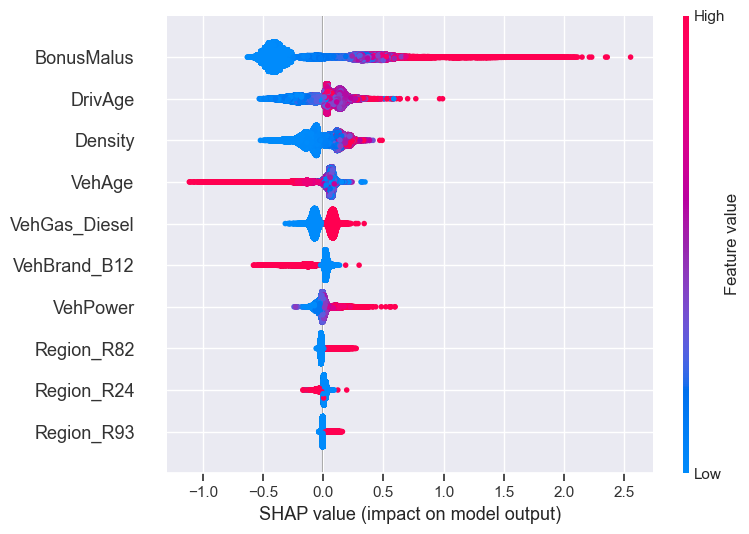

In [29]:
# define SHAP tree explainer for model_lgbm (default) and summarize the effects 

explainer_xgb2 = shap.TreeExplainer(model_xgb2)
shap_values_xgb2 = explainer_xgb2.shap_values(X_test)

shap.summary_plot(shap_values_xgb2, X_test, max_display=10)



[21:28:34] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_d6q0e1lomi/croot/xgboost-split_1713972719224/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
100%|===================| 135034/135051 [34:28<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


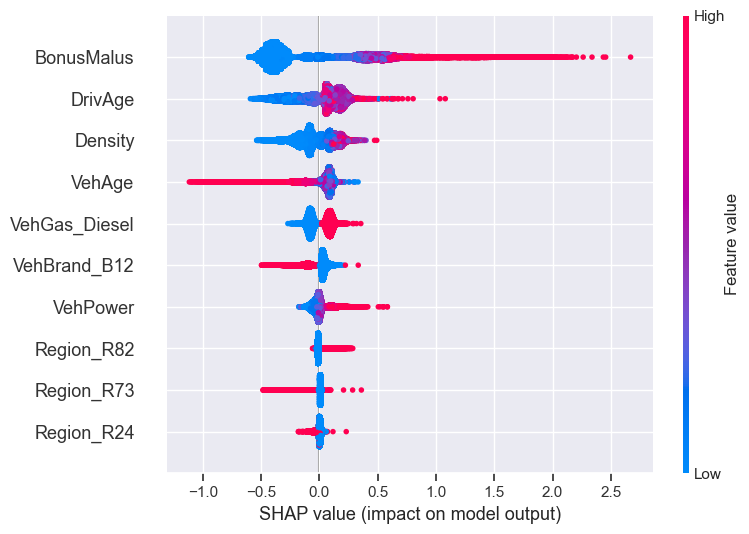

In [30]:
# set feature pertubation argument and background data for interventional approach

explainer_xgb2_int = shap.TreeExplainer(model=model_xgb2, data=X_learn, feature_perturbation='interventional')

shap_values_xgb2_int = explainer_xgb2_int.shap_values(X_test)

shap.summary_plot(shap_values_xgb2_int, X_test, max_display=10)

In [1]:
!jupyter nbconvert --to html XAI_notebookv1.ipynb

[NbConvertApp] Converting notebook XAI_notebookv1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 921907 bytes to XAI_notebookv1.html
